In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from glob import glob
from networkx.readwrite.graphml import read_graphml
from networkx.algorithms.shortest_paths.generic import shortest_path_length
import matplotlib.pyplot as plt
import patsy
import numpy as np
from scipy.stats import scoreatpercentile as SAP
from collections import defaultdict
from sklearn.metrics import roc_curve,RocCurveDisplay

plt.rcParams['svg.fonttype']='none'

## Preprocessing of the RNA-Seq data

In [2]:
data = pd.read_table("input_files/GSE152214_counts_new_GSM5227097-GSM5227106.txt.gz",index_col=1,sep=" ")
data2 = pd.read_table("input_files/GSE152214_Raw_counts.txt.gz",index_col=0,sep="\t")

TPM_l = []
for ctr,ds in enumerate([data,data2]):
    dstrt = 5 if ctr==0 else 4
    COUNTS = ds.iloc[:,dstrt:]
    META = ds.iloc[:,:dstrt]
    RPK = COUNTS.T/(META.Length/1000)
    TC = RPK.T.sum(axis=0)
    TPM = RPK.T/TC * 1e6
    TPM_l.append(TPM)
TPM_dat = pd.concat(TPM_l,axis=1)

from collections import defaultdict
my_d = defaultdict(dict)
for col in TPM_dat.columns:
    parts = col.split('_')
    if len(parts)==2:
        my_d[col]['strain']=parts[0].lower()
        my_d[col]['cultivation']='batch'
    elif len(parts)==3:
        if 'chemostat' in col:
            my_d[col]['strain']=parts[0].lower()
            my_d[col]['cultivation']='chemostat'
        else:
            my_d[col]['strain']='+'.join(parts[:2]).lower()
            my_d[col]['cultivation']='batch'


logTPM_dat = (np.log10(TPM_dat+1e-3)+3)

### Batch correct data to eliminate covariates

In [3]:
exp_meta = pd.DataFrame(dict(my_d)).T
n_array = logTPM_dat.shape[0]


mod = patsy.dmatrix("~0+strain",exp_meta,return_type='dataframe')
mod2 = patsy.dmatrix("~0 + cultivation",exp_meta,return_type='dataframe')
design = pd.concat([mod,mod2.loc[:,['cultivation[chemostat]']]],axis=1)
U,S,V = np.linalg.svd(design,full_matrices=False)
des_inv = np.dot(V.T*1/S**2,V)
des_inv_df = pd.DataFrame(des_inv,design.columns,design.columns)
B_hat = des_inv_df@design.T@logTPM_dat.T
var_pooled = (np.square(logTPM_dat-(design@B_hat).T) ).mean(axis=1)


In [4]:
def load_graph_stats(src='n23'):
    """Obtains the graph statistics relative to the crp gene."""
    G = read_graphml('results/rs2_irr_neg2.graphml')
    nd_lbl_d = {}
    lbl_nd_d = {}
    for nd in G.nodes(): 
        nd_lbl_d[nd]= G.nodes[nd]['label']
        lbl_nd_d[G.nodes[nd]['label']]= nd
    shrt_paths = pd.Series(dict([(nd_lbl_d[kk],vv) for kk,vv in shortest_path_length(G,src).items()]))
    in_degrees = pd.Series(dict([(nd_lbl_d[kk],vv) for kk,vv in G.in_degree()]))
    crp_signs = pd.Series(dict([(nd_lbl_d[nd],G.edges[src,nd]['weight']) for nd in G.successors(src)]))
    auto_reg_d = {}
    for nd in G.nodes():
        try:
            auto_reg_d[nd_lbl_d[nd]]=G.edges[nd,nd]['weight']
        except KeyError:
            auto_reg_d[nd_lbl_d[nd]]=0
    auto_reg = pd.Series(auto_reg_d)
    DF = pd.concat([shrt_paths, in_degrees, crp_signs, auto_reg],axis=1)
    DF = DF.fillna({0:np.inf,1:np.nan,2:0,3:np.nan,})
    DF.columns = ['shrt_path','in_degree','crp_signs','auto_reg']
    return DF,G

def extract_freq_of_irrev():
    freq_irrev = {}
    for fn in glob('results/df_summary*.csv'):
        parts = fn.split('/')[-1].split('.csv')[0].split('_')
        lbl = parts[-1]
        dat = pd.read_csv(fn,index_col=0).T
        freq_irrev[lbl]=dat
    return freq_irrev

graph_stats,G = load_graph_stats()
freq_irrev_d = extract_freq_of_irrev()

## Statistical analysis of the RNA-Seq data

In [5]:
from glob import glob
comp_sim_results = {}
for fn in glob('results/df_total_at_1_neg2_crp*.csv'):
    parts = fn.split('/')[-1].split('.csv')[0].split('_')
    lbl = '-'.join(parts[2:4] + parts[-1:])
    dat = pd.read_csv(fn,index_col=0)
    dat = dat.T[(dat>0).sum(axis=0)>0].T
    dat.index = pd.MultiIndex.from_tuples([kk.split('-') if '-' in kk else ('1','0') for kk in dat.index])
    cp_grps = dat.groupby(level=0).mean()
    for num,row in cp_grps.iterrows():
        comp_sim_results[(lbl,num)]=row
    ovr = cp_grps.mean()
    #comp_sim_results[(lbl,'ovr')]=ovr
    #for gn in set(selected_genes)-set(cp_grps.columns):
    #    cp_grps[gn]=0
    #ovr_rank = cp_grps.sum(axis=0).rank()
comp_sim_results_df = pd.DataFrame(comp_sim_results)
comp_sim_results_df=comp_sim_results_df.T[np.any(comp_sim_results_df.fillna(0)!=0,axis=0)].T
srt_vals = comp_sim_results_df.mean(axis=1).sort_values()

G = read_graphml('results/rs2_irr_neg2.graphml')
nd_lbl_d = {}
lbl_nd_d = {}
for nd in G.nodes(): 
    nd_lbl_d[nd]= G.nodes[nd]['label']
    lbl_nd_d[G.nodes[nd]['label']]= nd


crp_shrt_paths = pd.Series(dict([(nd_lbl_d[kk],vv) for kk,vv in shortest_path_length(G,'n23').items()]))
in_degrees = pd.Series(dict([(nd_lbl_d[kk],vv) for kk,vv in G.in_degree()]))
crp_signs = pd.Series(dict([(nd_lbl_d[nd],G.edges['n23',nd]['weight']) for nd in G.successors('n23')]))

auto_reg_d = {}
for nd in G.nodes():
    try:
        auto_reg_d[nd_lbl_d[nd]]=G.edges[nd,nd]['weight']
    except KeyError:
        auto_reg_d[nd_lbl_d[nd]]=0
auto_reg = pd.Series(auto_reg_d)


DF = pd.concat([srt_vals, crp_shrt_paths, in_degrees, crp_signs, auto_reg],axis=1)
DF = DF.fillna({0:0,1:np.inf,2:0,3:np.nan,4:0})
DF.columns = [('','','irr_prob'),('','','shrt_path'),('','','in_degree'),('','','crp_signs'),('','','auto_reg')]
DF.columns = pd.MultiIndex.from_tuples(DF.columns)


state_cols_d = {('wt','batch'):['WT_S1','WT_S2'],
                ('crp','batch'):['CRP_S1','CRP_S2'],
                ('evo1','batch'):['Evocrp1_S1','Evocrp1_S2'],
                ('evo2','batch'):['Evocrp2_S1','Evocrp2_S2'],
                ('evo3','batch'):['Evocrp3_S1','Evocrp3_S2'],
                ('evo4','batch'):['Evocrp4_S1','Evocrp4_S2'],
                ('evo5','batch'):['Evocrp5_S1','Evocrp5_S2'],
                ('mut','batch'):['IG116_crp_S1','IG116_crp_S2'],
                ('wt','chemo'):['WT_chemostat_S1','WT_chemostat_S2'],
                ('crp','chemo'):['CRP_chemostat_S1','CRP_chemostat_S2'],
                ('evo1','chemo'):['EvoCrp1_chemostat_S1','EvoCrp1_chemostat_S2'],
                ('evo3','chemo'):['EvoCrp3_chemostat_S1','EvoCrp3_chemostat_S2'],
               }

statepair_cols_l = [
                ('crp','wt','batch'), ('crp','wt','chemo'),
                ('evo1','wt','chemo'), ('evo3','wt','chemo'),
                ('evo1','wt','batch'), ('evo2','wt','batch'),
                ('evo3','wt','batch'), ('evo4','wt','batch'),
                ('evo5','wt','batch'), ('mut','wt','batch')]

states_d ={}
avgexp_d={}
stdexp_d={}
cvexp_d = {}
from scipy.stats import scoreatpercentile as SAP

for (st,lbl),cols in state_cols_d.items():
    states_d[(st,lbl)]= TPM_dat.loc[:,cols]
    MUS = TPM_dat.loc[:,cols].mean(axis=1)
    avgexp_d[(st,'mean',lbl)] = MUS
    SIGS = TPM_dat.loc[:,cols].std(axis=1)
    CV = SIGS/MUS
    lbcv,ubcv = SAP((CV[MUS>1]),[5,95])
    LB = MUS*lbcv
    UB = MUS*ubcv
    stdexp_d[(st,'sig',lbl)] = SIGS.clip(LB,UB)
    cvexp_d[(st,'cv',lbl)] = SIGS.clip(LB,UB)/MUS
    #print(st,lbl,lbcv,ubcv)

    
avgexp_df = pd.DataFrame(avgexp_d)
stdexp_df = pd.DataFrame(stdexp_d)
cvexp_df = pd.DataFrame(cvexp_d)

zv_d = {}
for st_f,st_i,ccond in statepair_cols_l:
    fin = states_d[(st_f,ccond)]
    init = states_d[(st_i,ccond)]
    pooled_sig = np.sqrt(pd.concat([(fin.T-fin.mean(axis=1))**2,(init.T-init.mean(axis=1))**2]).sum()/2)
    fc = fin.mean(axis=1)/init.mean(axis=1)
    fc_sig = np.sqrt((cvexp_df.loc[:,(st_i,'cv',ccond)])**2 + (cvexp_df.loc[:,(st_f,'cv',ccond)])**2)
    zv_d[(st_f,st_i,ccond+'_fc')] = fc
    zv_d[(st_f,st_i,ccond+'_fcsig')] = fc_sig
zv_df = pd.DataFrame(zv_d)

combined_table = pd.concat([DF,zv_df,avgexp_df,stdexp_df,cvexp_df],axis=1)
combined_table=combined_table.loc[DF.index]

C1 = (combined_table.xs('shrt_path',level=2,axis=1)<2).iloc[:,0] 
C2 = (combined_table.xs('in_degree',level=2,axis=1)<3).iloc[:,0]
CA = (combined_table.xs(('wt','batch'),level=[0,2],axis=1)>1).iloc[:,0]
CB = (combined_table.xs(('wt','chemo'),level=[0,2],axis=1)>1).iloc[:,0]

## Fig. S4

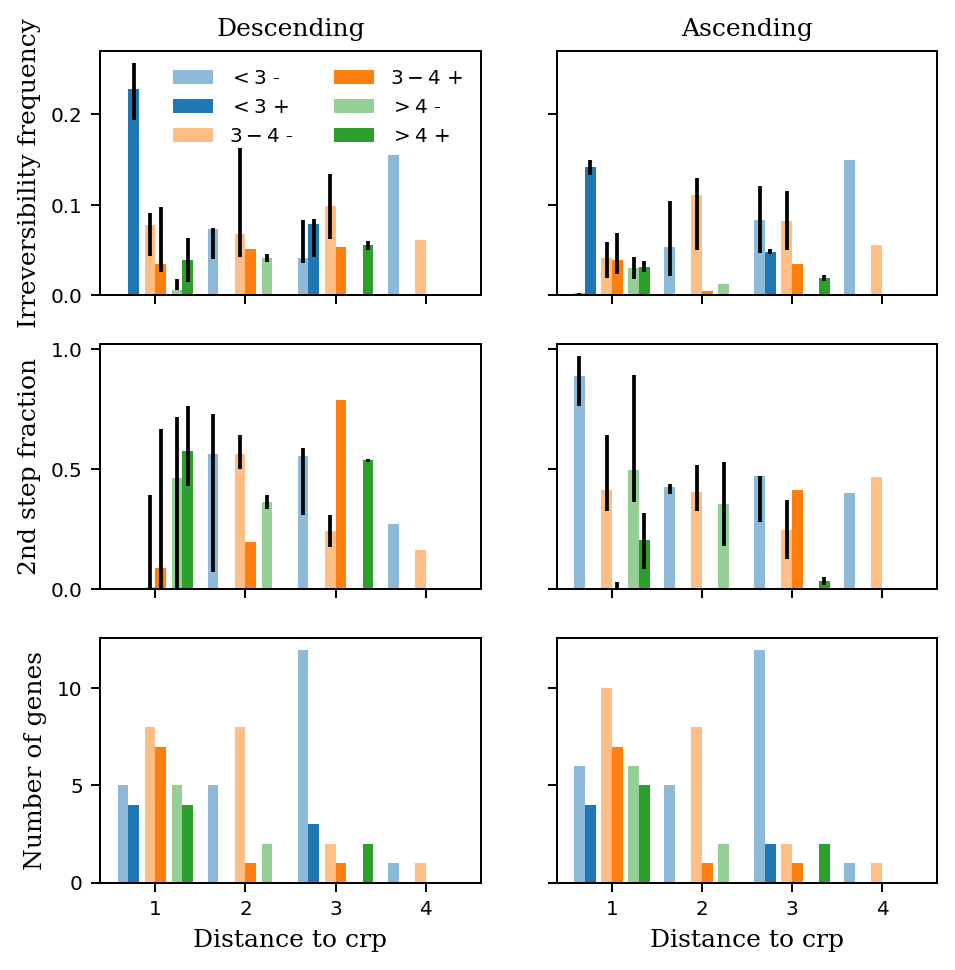

In [6]:
fig,ax = plt.subplots(3,2,dpi=180,sharex='col',sharey='row',figsize=(6,6))
so_chng_diff_d = {}
alpha_d = {-1:0.5,0:0.1,1:1}
chng_tot = {}
for jj,kw in enumerate(['so','inv']):
    so_chng1 = freq_irrev_d[kw].loc[:,'mean changed at 1']
    so_chng2 = freq_irrev_d[kw].loc[:,'mean changed by 2']
    so_chng_diff_d[kw] = (so_chng2 - so_chng1)/so_chng2
    chng_tot[kw] = freq_irrev_d[kw].loc[:,'mean changed by 2']
    common_inds = so_chng_diff_d[kw].index.intersection(graph_stats.index)
    bar_data_d = {}
    for p2crp,grp in graph_stats.groupby('shrt_path'):
        if np.isinf(p2crp) or p2crp==0:
            continue
        cnt3 = 0
        for bname,ggrp in pd.cut(grp.in_degree,[0,2.5,4.5,13]).to_frame().groupby('in_degree'):
            if cnt3 ==1:
                bnn = '<=2'
            elif cnt3 <2:
                bnn = '3-4'
            else:
                bnn = '>4'
            cnt3+=1
            cnt2 = 0
            for aname,sgrp in pd.cut(grp.loc[ggrp.index].auto_reg,[-1.5,0.5,1.5]).to_frame().groupby('auto_reg'):
            #for aname,sgrp in graph_stats.loc[ggrp.index].groupby('auto_reg'):
                nmm = -1 if cnt2==0 else 1
                ci2 = common_inds.intersection(sgrp.index)
                bar_data_d[(bnn,nmm,p2crp,'mu')] = so_chng_diff_d[kw].loc[ci2].median()
                bar_data_d[(bnn,nmm,p2crp,'pct25')] = SAP(so_chng_diff_d[kw].loc[ci2],25)
                bar_data_d[(bnn,nmm,p2crp,'pct75')] = SAP(so_chng_diff_d[kw].loc[ci2],75)
                bar_data_d[(bnn,nmm,p2crp,'n_gn')] = len(ci2)
                bar_data_d[(bnn,nmm,p2crp,'tot50')] = chng_tot[kw].loc[ci2].median()
                bar_data_d[(bnn,nmm,p2crp,'tot25')] = SAP(chng_tot[kw].loc[ci2],25)
                bar_data_d[(bnn,nmm,p2crp,'tot75')] = SAP(chng_tot[kw].loc[ci2],75)
                cnt2+=1
    bar_data_df = pd.Series(bar_data_d).unstack().fillna(0)
    width=0.12
    cnt = 0
    lbl = [r'$<3$',r'$3-4$',r'$>4$']
    lbl2 = [r'-',r'+']
    for bname,bgrp in bar_data_df.groupby(level=0):
        cnt1=0
        for aname,sgrp in bgrp.groupby(level=1):
            #print(aname)
            xvals = sgrp.index.get_level_values(2) + ((cnt-1)*2.5+(cnt1-0.5))*width 
            yvals0 = sgrp.tot50.values
            yerrs0 = np.c_[yvals0-sgrp.tot25.values,sgrp.tot75.values-yvals0].T
            yvals = sgrp.mu.values
            yvals2 = sgrp.n_gn.values
            yerrs = np.c_[yvals-sgrp.pct25.values,sgrp.pct75.values-yvals].T
            ax[0,jj].bar(xvals,yvals0,color='C%d'%cnt,yerr=yerrs0,width=width,label=' '.join([lbl[cnt],lbl2[cnt1]]),alpha=alpha_d[int(aname)])
            ax[1,jj].bar(xvals,yvals,color='C%d'%cnt,yerr=yerrs,width=width,label=' '.join([lbl[cnt],lbl2[cnt1]]),alpha=alpha_d[int(aname)])
            ax[2,jj].bar(xvals,yvals2,color='C%d'%cnt,width=width,alpha=alpha_d[int(aname)])
            cnt1+=1
        cnt+=1
    if jj==0:
        ax[0,0].legend(frameon=False,loc=1,prop={'size':8,'family':'serif'},ncol=2)
        
    ax[2,jj].set_xlabel('Distance to crp',family='serif')
    ax[0,0].set_ylabel('Irreversibility frequency',family='serif')
    ax[1,0].set_ylabel('2nd step fraction',family='serif')
    ax[2,0].set_ylabel('Number of genes',family='serif')
    ax[2,jj].set_xticks([1,2,3,4])
    ax[2,jj].set_xticklabels(['%d' % elt for elt in [1,2,3,4]],size=8)
    for kk in range(3):
        plt.setp(ax[kk,0].get_yticklabels(),size=8)
    if kw =='so':
        ax[0,jj].set_title('Descending',size=10,family='serif')
    elif kw == 'inv':
        ax[0,jj].set_title('Ascending',size=10,family='serif')

fig.savefig('figs/figS2_fraction_second_step3.svg')    
    

## Fig. 6 and Fig. S5

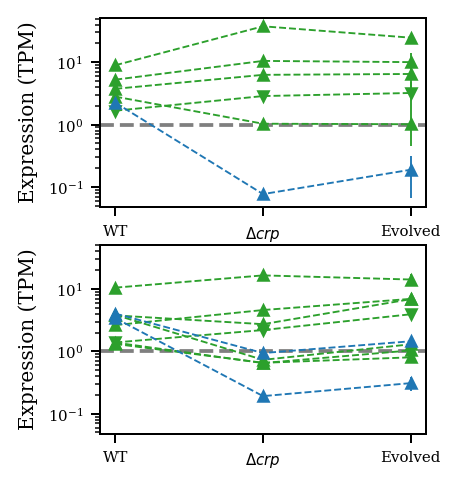

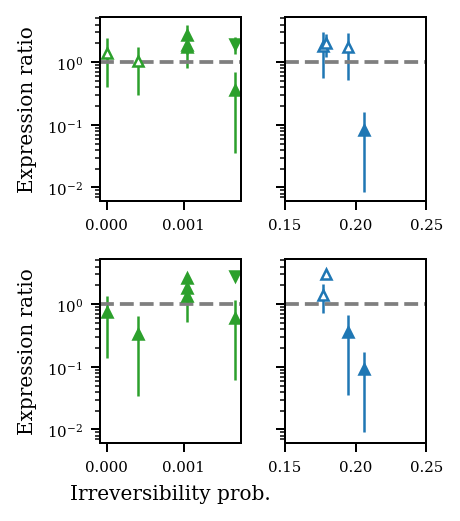

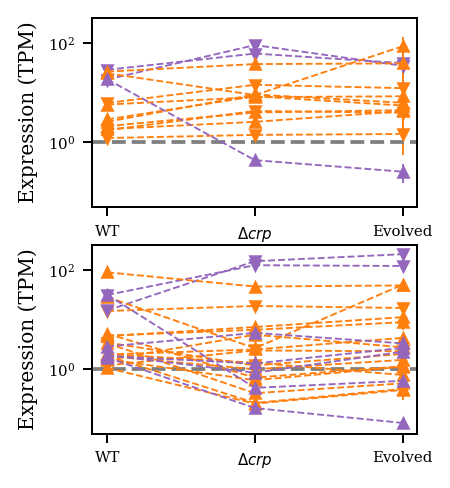

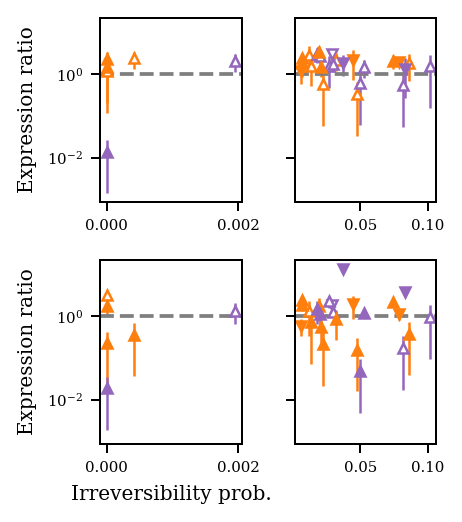

In [7]:
aa=True
CC1 = C1 if aa else ~C1
nm='direct' if aa else 'indirect'
for bb in [True,False]:
    tp = 'exclusive' if bb else 'inclusive'
    ex_fig,ex_arr = plt.subplots(2,1,dpi=180,figsize=(2.33,3),sharey=True)
    fc_fig,fc_arr = plt.subplots(2,2,dpi=180,figsize=(2.66,3),sharey=True)
    CC2 = C2 if bb else ~C2
    for cc in [False,True]:
        for zz,ccond in enumerate(['batch','chemo']):
            if zz==0:
                CC3 = CA if cc else ~CA
            else:
                CC3 = CB if cc else ~CB
            SEL = CC1 & CC2 & CC3
            GB = combined_table[SEL].groupby([('','','crp_signs'),('','','auto_reg')]) if aa else combined_table[SEL].groupby([('','','auto_reg')])
            dtup,grp = list(GB)[0]
            for dtup,grp in GB:
                if aa:
                    crp_sgn,areg =dtup
                    msym = '^' if crp_sgn>0 else 'v'
                else:
                    areg=dtup
                    crp_sgn=np.nan
                    msym='o'
                if bb:
                    clr='C0' if areg>0 else 'C2'
                else:
                    clr='C4' if areg>0 else 'C1'
                if cc:
                    fclr = clr
                else:
                    fclr = 'w'
                xvals0 = grp.loc[:,('','','irr_prob')]
                if aa and bb:
                    IP_COND = xvals0<1e-2
                elif aa and not bb:
                    IP_COND = xvals0<5e-3
                elif not aa:
                    IP_COND = xvals0<5e-2
                xvals0a=xvals0[IP_COND]
                xvals0b=xvals0[~IP_COND]
                xvals1 = np.arange(3)                
                zz_vals = ['evo%d' % ii for ii in range(1,6)]+['mut'] if zz==0 else ['evo1','evo3']
                yvals1_l = []
                yverr1_l = []
                #for num in zz_vals:
                yvals0 = pd.concat([grp.loc[:,(num,'wt','%s_fc' % ccond)] for num in zz_vals],axis=1).mean(axis=1)
                yvals0a = yvals0[IP_COND]
                yvals0b = yvals0[~IP_COND]
                yverr0 = np.sqrt(pd.concat([grp.loc[:,(num,'wt','batch_fcsig')]**2 for num in zz_vals],axis=1).sum(axis=1))
                yverr0a = yverr0[IP_COND]
                yverr0b = yverr0[~IP_COND]
                fc_arr[zz,0].errorbar(xvals0a,yvals0a,yerr=yverr0a.clip(0,.9*yvals0a),
                                      ms=4,mec=clr,mfc=fclr,marker=msym,ls='',color=clr,elinewidth=1)
                fc_arr[zz,1].errorbar(xvals0b,yvals0b,yerr=yverr0b.clip(0,.9*yvals0b),
                                      ms=4,mec=clr,mfc=fclr,marker=msym,ls='',color=clr,elinewidth=1)
                yvals1_l.extend([grp.loc[:,(num,'mean',ccond)] for num in zz_vals])
                yverr1_l.extend([grp.loc[:,(num,'sig',ccond)] for num in zz_vals])
                evoyv1 = pd.concat(yvals1_l,axis=1)
                yvals1 = pd.concat([grp.loc[:,('wt','mean',ccond)],grp.loc[:,('crp','mean',ccond)],evoyv1.mean(axis=1)],axis=1)
                yverr1 = pd.concat([grp.loc[:,('wt','sig',ccond)],grp.loc[:,('crp','sig',ccond)],evoyv1.std(axis=1)],axis=1)
                for gn,row in yvals1.iterrows():
                    err = yverr1.loc[gn]
                    if cc:
                        ex_arr[zz].errorbar(xvals1,row,yerr=[0,0,err.iloc[-1]],mec=clr,mfc=fclr,ms=4,marker=msym,ls='--',color=clr,lw=0.75) #yerr=err

    for ii in range(2):
        ex_arr[ii].set_xticks([0,1,2])
        ex_arr[ii].set_xticklabels(['WT',r'$\Delta crp$','Evolved'],size=6,family='serif')
        ex_arr[ii].set_yscale('log')
        ex_arr[ii].axhline(1,ls='--',color='C7')
        plt.setp(ex_arr[ii].get_yticklabels(),size=6,family='serif')
        for jj in range(2):
            fc_arr[ii,jj].set_yscale('log')
            fc_arr[ii,jj].axhline(1,ls='--',color='C7')
            plt.setp(fc_arr[ii,jj].get_xticklabels(),size=6,family='serif')
            plt.setp(fc_arr[ii,jj].get_yticklabels(),size=6,family='serif')
        #if nm == 'direct':
        #    ex_arr[ii,1].set_xscale('log')
    if nm=='indirect' and tp=='exclusive':
        ex_arr[0].set_ylim(0.5,50)
        ex_arr[1].set_ylim(0.5,50)
    if nm=='direct' and tp=='exclusive':
        #fc_arr[0,0].set_xlim(3e-3,1e-2)
        #fc_arr[1,0].set_xlim(3e-3,1e-2)
        fc_arr[0,1].set_xlim(0.15,0.25)
        fc_arr[1,1].set_xlim(0.15,0.25)
    #elif nm!='direct':
        #fc_arr[0,1].set_xlim(-0.05,0.125)
        #fc_arr[1,1].set_xlim(-0.05,0.125)
        #fc_arr[0,1].set_xlim(-0.05,0.125)
        #fc_arr[1,1].set_xlim(-0.05,0.125)

    fc_arr[1,0].set_ylabel('Expression ratio',size=8,family='serif')
    fc_arr[0,0].set_ylabel('Expression ratio',size=8,family='serif')
    ex_arr[1].set_ylabel('Expression (TPM)',size=8,family='serif')
    ex_arr[0].set_ylabel('Expression (TPM)',size=8,family='serif')        
    fc_arr[1,0].set_xlabel('Irreversibility prob.',size=8,family='serif')
    #ax_arr[1,0].set_xlabel('Strain',size=8)
    plt.tight_layout()
    ex_fig.savefig('figs/%s_%s_expression.svg' % (nm,tp))
    fc_fig.savefig('figs/%s_%s_foldchange.svg' % (nm,tp))

### ROC curves

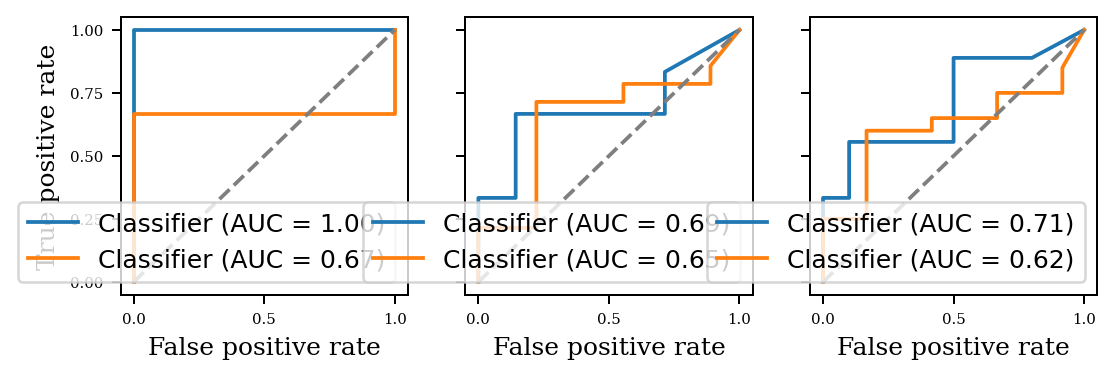

In [8]:
## ignore genes with <1 TPM expression.
## sort in descending order of the irreversibility probability
## classify as responding according to irreversibility response or against
## fc <1 if upregulated; fc >1 if downregulated
## then plot the ROC-AUC curve 
ROC_data_d = defaultdict(dict)
for isExcl in [True,False]:
    tp = 'exclusive' if isExcl else 'inclusive'
    CC2 = C2 if isExcl else ~C2
    for isDirect in [True]:
        CC1 = C1 if isDirect else ~C1
        nm='direct' if isDirect else 'indirect'
        for zz,isBatch in enumerate([True,False]):
            CC3,ccond = (CA,'batch') if isBatch else (CB,'chemo')
            ## ignoring expression below 1 TPM for now
            SEL = combined_table[CC1 & CC2 & CC3]
            xvals0 = SEL.loc[:,('','','irr_prob')]
            zz_vals = ['evo%d' % ii for ii in range(1,6)]+['mut'] if isBatch else ['evo1','evo3']
            yvals0 = SEL.loc[:,[(num,'wt','%s_fc' % ccond) for num in zz_vals]].mean(axis=1)
            TF = np.sign(SEL.loc[:,('','','crp_signs')]*-1) == np.sign(np.log(yvals0.loc[SEL.index]))
            comb_df = pd.concat([xvals0,TF],axis=1)
            comb_df.columns = ['irr_prob','data_match']
            ROC_data_d[ccond][tp] = comb_df

ROC_data_d = dict(ROC_data_d)

fig,ax = plt.subplots(1,3,figsize=(7,2),dpi=180,sharey=True)
for reg in ['exclusive','inclusive']:
    ax_col = 0 if reg=='exclusive' else 1
    for ccond,dat in ROC_data_d.items():
        OP = RocCurveDisplay.from_predictions(dat[reg].data_match,dat[reg].irr_prob,pos_label=True,ax=ax[ax_col])
    ax[ax_col].set_xlabel('False positive rate',family='serif')
    if ax_col==0:
        ax[ax_col].set_ylabel('True positive rate',family='serif')
    else:
        ax[ax_col].set_ylabel('',family='serif')
    plt.setp(ax[ax_col].get_xticklabels(),size=6,family='serif')
    plt.setp(ax[ax_col].get_yticklabels(),size=6,family='serif')
    ax[ax_col].plot(np.linspace(0,1),np.linspace(0,1),ls='--',color='C7')
for ccond,dat in ROC_data_d.items():
    comb_data = pd.concat([dat[reg] for reg in ['exclusive','inclusive']],axis=0)
    OP = RocCurveDisplay.from_predictions(comb_data.data_match,comb_data.irr_prob,pos_label=True,ax=ax[2])
ax[2].set_xlabel('False positive rate',family='serif')
ax[2].set_ylabel('',family='serif')
plt.setp(ax[2].get_xticklabels(),size=6,family='serif')
plt.setp(ax[2].get_yticklabels(),size=6,family='serif')
ax[2].plot(np.linspace(0,1),np.linspace(0,1),ls='--',color='C7')
fig.savefig('figs/roc_auc_curves.svg')